In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.main import single_fitting_cycle
from main.seir.forecast import create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.uncertainty import plot_beta_loss
from data.dataloader import SimulatedDataLoader
from joblib import delayed, Parallel

import yaml
import wandb

## Configuration

In [ ]:
simulated_config_filename = 'seirhd_fixed.yaml'
config_filename = 'simulate_data.yaml'
n_iters = 2  # Number of iterations of a single fitting cycle for each PL curve
n_jobs = 1  # Parallelization parameter : How many parallel jobs to run
varying_perc = np.array([-0.1, -0.25, -0.5, -0.75, -0.9, 0.0, 0.1, 0.25, 0.5, 0.75, 0.9]) # Percentage Change from true value for each parameter
save_dir = '../../misc/predictions/sens_prof/'
out_file = 'profile_likelihood'

In [ ]:
# instead of taking all parameters and removing some, take input of what parameters to vary
with open(os.path.join("../../configs/simulated_data/", simulated_config_filename)) as configfile:
    simulated_config = yaml.load(configfile, Loader=yaml.SafeLoader)    
run_config = read_config(config_filename)

fitting_config = copy.deepcopy(run_config['fitting'])
params_to_include = fitting_config['variable_param_ranges'].keys()

## Simulate Data and Save It (Set Generate to False)

In [ ]:
dataloader_class = SimulatedDataLoader()
data_dict = dataloader_class.pull_dataframes(**simulated_config)
simulated_data_path = simulated_config['output_file_name']

## Function to Return Parameter Value For Your Model

In [ ]:
def get_hosp_ratio_at_time(param_name,simulated_data_file, split_config):
    df = pd.read_csv(os.path.join('../../data/data/simulated_data/', simulated_data_file), index_col=0)
    if split_config['end_date']:
        end_date = split_config['end_date']
        if isinstance(end_date, int):
            if end_date > 0:
                raise ValueError('Please enter a negative value for end_date if entering an integer')
            else : 
                end_date_offset = end_date
        if isinstance(end_date, datetime.date):
            df['date'] = pd.to_datetime(df['date'])
            end_date_offset = df.loc[df['date'].dt.date == split_config['end_date']].index[0] - len(df) + 1
    else:
        end_date_offset = 0
    train_start_row = df.iloc[len(df) - (split_config['train_period'] + split_config['val_period'] + split_config['test_period']) + end_date_offset]
    if param_name == 'E_hosp_ratio':
        return train_start_row['E'] / train_start_row['active']
    elif param_name == 'I_hosp_ratio':
        return train_start_row['I'] / train_start_row['active']
    else : 
        raise NotImplementedError('Parameter value retrieval for ',param_name,' not implemented')

In [ ]:
def get_param_value(param, perc_change, config_params, simulated_config):
    if 'hosp_ratio' in param:
        actual_value = get_hosp_ratio_at_time(param,simulated_config['output_file_name'],fitting_config['split'])
        test_value = actual_value*(1+perc_change)
    else :
        actual_value = simulated_config['params'][param]
        test_value = actual_value*(1+perc_change)
    return test_value

## List all single fitting cycle runs

In [ ]:
run_tuples = []
for param in params_to_include:
    for perc_change in varying_perc : 
        test_value = get_param_value(param,perc_change,fitting_config,simulated_config)
        for i in range(n_iters):
            run_tuples.append({'param':param, 'perc_change':perc_change, 'test_value':test_value, 'iter':i})

## Function to Parallelize Fitting Cycle Runs

In [ ]:
def run_bo(fitting_config,run_tuple):
    conf = copy.deepcopy(fitting_config)
    if param in conf['variable_param_ranges']:
        del conf['variable_param_ranges'][param] 
    conf['default_params'][param] = run_tuple['test_value']
    predictions_dict = single_fitting_cycle(**conf)
    output = {}
    output['losses'] = predictions_dict['df_loss']
    output['best_params'] = predictions_dict['best_params']
    output['run_tuple'] = run_tuple
    return output

In [ ]:
run_tuples[4]

## Main Function

In [ ]:
losses = Parallel(n_jobs=n_jobs)(
    delayed(run_bo)(fitting_config, run_tuples[i]) for i in range(len(run_tuples))
)

In [ ]:
# Saving Output into a pickle file

output_dict = {}
output_dict['data_config'] = simulated_config
output_dict['model_config'] = config
output_dict['params_to_fix'] = params_to_fix
output_dict['losses'] = losses

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
with open(os.path.join(save_dir, out_file+".pickle"), 'wb') as handle:
    pkl.dump(output_dict, handle)

## MCMC

In [ ]:
config_filename = 'mcmc_simulate.yaml'
config = read_config(config_filename)

In [ ]:
predictions_dict_mcmc = single_fitting_cycle(**copy.deepcopy(config['fitting']))

In [ ]:
parameter_names = list(predictions_dict_mcmc['trials']['params'][0].keys())
params_array = predictions_dict_mcmc['trials']['params']

In [ ]:
params_dict = {param: [param_dict[param] for param_dict in params_array]
                for param in parameter_names}

In [ ]:
df = pd.DataFrame.from_dict(params_dict)
import seaborn as sns
CM = df.corr()
fig = plt.figure(figsize = (16,14))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap = 'coolwarm')

{}

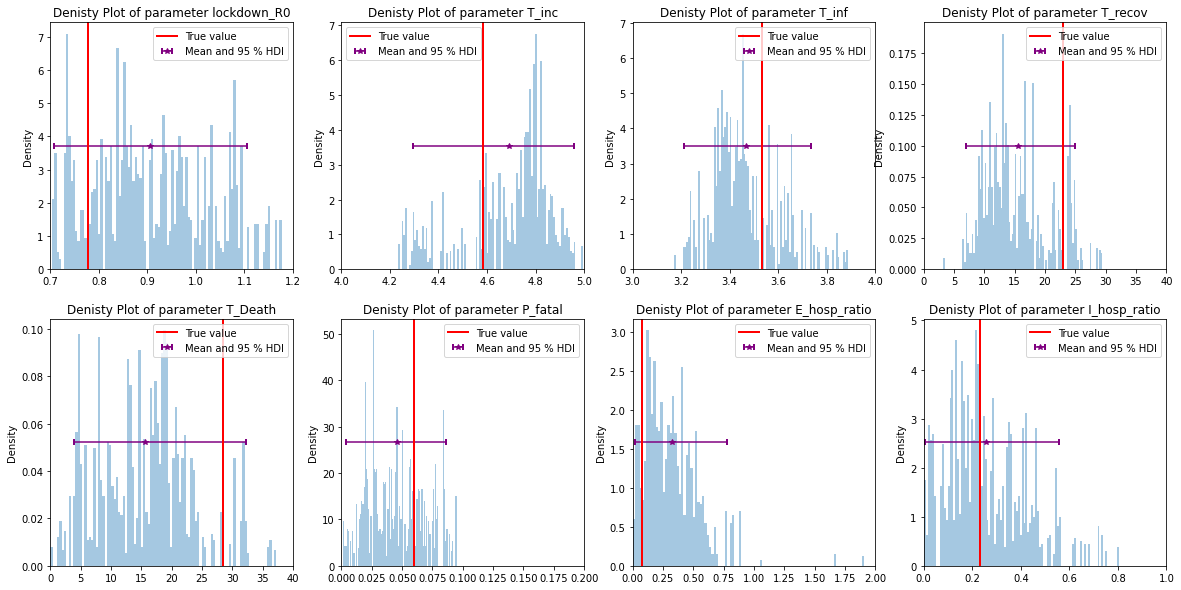

In [51]:
import matplotlib.pyplot as plt
from viz.fit import plot_histogram
fig,axs = plt.subplots(2,4,figsize=(20,10))
plot_histogram(params_dict,arr=parameter_names,true_val  = params_array[0],fig = fig,axs = axs)